# Multiple imaging

Let's explore simulation of signals generated by neutron stars sufficiently compact to generate multiple images of a subset or even all of the surface. 

Previous versions of this tutorial used to also demonstrate the correctness for an oblate surface embedded in an ambient Schwarzschild spacetime by calling multiple different integrators and using the simple [rayXpanda](https://github.com/ThomasEdwardRiley/rayXpanda) package. If interested, those can be found by checking the early GitHub history of this tutorial. However, in the current form we focus only on studying the effects of different image orders on the pulse profiles.

Ultimately, we conclude that the inclusion of secondary images is important in practice, whilst the inclusion of tertiary images is unimportant in practice, and the inclusion of quaternary order and higher is entirely unnecessary as far as we can foresee.

**Note that if you wish to execute this notebook as is, it is costly because we use rather high-resolution calculations. You can also lower the integrator resolution settings and change the model parameters including the stellar spin frequency, the spacetime properties, and the source-receiver configuration.**

In the first part of this tutorial we calculate signals with no image order limit for a reference. This means that images will be summed over until higher order images are not visible or the visibility limit is truncated due to lack of numerical precision. We use a surface radiation field that is globally uniform (see a similar approach in *Global surface emission* tutorial) and an effectively spherical star by entering the limit of zero spin.

In [1]:
%matplotlib inline

from __future__ import print_function, division

import os
import numpy as np
import math

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm

from IPython.display import Image

import xpsi
from xpsi import Parameter
from xpsi.utilities import PlottingLibrary as XpsiPlot

from xpsi.global_imports import _c, _G, _dpr, gravradius, _csq, _km, _2pi

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 3.0.6               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported emcee version: 3.1.6
Imported PyMultiNest.
Imported UltraNest.
Imported GetDist version: 1.5.3
Imported nestcheck version: 0.2.1


First we need to do some setup of the ambient spacetime and the surface embedded in it that the photosphere exists on.

In [2]:
bounds = dict(frequency = (0.1, 600.0),
              distance = (0.1, 1.0),                     # (Earth) distance
              mass = (1.0, 3.0),                         # mass
              radius = (3.0 * gravradius(1.0), 16.0),    # equatorial radius
              cos_inclination = (0.0, 1.0))              # (Earth) inclination to rotation axis

spacetime = xpsi.Spacetime(bounds=bounds, values=dict(frequency=0.1)) # spherical star

Creating parameter:
    > Named "frequency" with bounds [1.000e-01, 6.000e+02] and initial value 1.000e-01.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-01, 1.000e+00].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [0.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


## Default (phase-invariant)

First we invoke a globally uniform temperature field. There is no azimuthal dependence, meaning that the signal generated by the star is time-invariant. We are in need of an object that embeds a *globally* discretised surface into the ambient spacetime and exposes methods for integration over solid angle on our sky. 

In [3]:
bounds = dict(temperature = (None, None))

everywhere = xpsi.Everywhere(time_invariant=True,
                             bounds=bounds,
                             values={}, # no fixed/derived variables
                             sqrt_num_cells=1024, # in colatitude, and in azimuth separately
                             num_rays=1024, # O(1000) useful for secondary and tertiary images
                             num_leaves=1024, # specify leaves if time-dependent
                             num_phases=100, # of the output signal
                             image_order_limit=None) # as many images as possible within resolution

Creating parameter:
    > Named "temperature" with bounds [3.000e+00, 7.600e+00].
    > log10(effective temperature [K] everywhere).
Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.


We are free to subclass [Everywhere](everywhere.rst#xpsi.Everywhere.Everywhere) and implement custom functionality beyond the simple default above. The argument specifying the number of rays has the familiar meaning. The argument for the number of cells is now used to discretise the surface in azimuth and colatitude with respect to the stellar rotation axis, as was the case for the [Elsewhere](elsewhere.rst#xpsi.Elsewhere.Elsewhere) module. The new argument ``time_invariant`` declares whether or not the surface radiation field is dependent on azimuth; if it is independent of azimuth, a faster integrator is called.

Now we need an instance of [Photosphere](photosphere.rst#xpsi.Photosphere.Photosphere) that we can feed our ``everywhere`` object to. 

In [4]:
class derive(xpsi.Derive):
    def __init__(self):
        pass
    def __call__(self, boundto, caller = None):
        global spacetime
        return spacetime['frequency']

In [5]:
photosphere = xpsi.Photosphere(hot = None, elsewhere = None, everywhere = everywhere,
                               values=dict(mode_frequency = derive()))

Creating parameter:
    > Named "mode_frequency" that is derived from ulterior variables.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].


In [6]:
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

Let's check the vector of parameter values in the ``Star`` instance and the other objects it encapsulates references to.

In [7]:
star

Free parameters
---------------
frequency: Spin frequency [Hz].
mass: Gravitational mass [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
cos_inclination: Cosine of Earth inclination to rotation axis.
temperature: log10(effective temperature [K] everywhere).

We assign parameter values and update the star as follows:

In [8]:
# (Earth) distance
star['distance'] = 0.33
# gravitational mass
star['mass'] = 2.7088795
# coordinate equatorial radius
star['radius'] = 12.0
# (Earth) inclination to rotation axis
star['cos_inclination'] = math.cos(1.0)
# isotropic blackbody temperature
star['temperature'] = 6.3

star.update()

The temperature is chosen to be something appropriately hot for the energy range, so that the specific flux at the lowest energies is *not* dominated by bright stellar limb, which will be the case for targets in X-ray telescope wavebands. More on this later.

In [9]:
spacetime.R_r_s # rather compact! effectively @ the Schwarzschild photon sphere

1.5000001812176318

Let's see what the maximum deflection is calculated to be conditional on the resolution:

In [10]:
everywhere._maxDeflection[0]/xpsi.global_imports._pi

5.44436523851195

A true maximum deflection of this value, for a spherical star, would mean a subset of the stellar surface would be imaged *six* times. This subset is defined by having a *principal* deflection of $\psi\gtrsim(1-0.4444)\pi$, meaning a spherical cap of this angular radius centred on the direction between Earth and the centre of the star. The subset of the surface with *principal* deflection of $\psi\lesssim(1-0.4444)\pi$, and by definition less than $\pi$, is *only* imaged *five* times.

Let's compute the incident specific flux signal, up to some constant coefficient.

In [11]:
energies = np.logspace(-2.0, np.log10(3.0), 100, base=10.0)

In [12]:
photosphere.integrate(energies=energies, threads=4) # calls to xpsi/cellmesh/integrator_for_time_invariance.pyx

The signal is time-invariant and therefore we need to copy the spectrum to a sequence of matrix columns to get the desired energy-phase signal matrix:

In [13]:
phases_in_cycles = 100
temp_int1 = np.tile(photosphere.signal[0][0], (1,phases_in_cycles))

## Decreasing the image order limit

For integrators that directly discretise the stellar surface with a regular mesh (e.g. for the time invariant integrator used here) we can straightforwardly control the limiting image order to try to sum up to. If the image order is conservative, the integrators automatically detect invisibility and truncate. Note that the sum is executed from low- to high-order, which generally means adding small numbers to much larger numbers, and thus in principle accuracy loss, but the number magnitude decays very rapidly with order so the contribution from combining higher-order images first shouldn't make an importance difference. If higher-order images are visible, they are simply missed because of enforced truncation. It follows that because the flux contribution from higher-order images (even at fixed phase and energy) decays with order, setting a limit of three images or even two images is going to be entirely sufficient in practice. On the other hand, not setting a limit won't affect integration time in an important way for less compact stars, but if prior support extends to very compact stars, the computation time increases by a factor of a few, until the resolution limit is reached.

Choosing a limit of two or three, and allowing the prior support to encompass configurations with polar radius greater than the Schwarzschild photon sphere radius should be sufficient. Then, if of interest, incrementing the order limit during post-processing to execute sensitivity analysis via importance sampling should allow one to demonstrate insensitivity to higher-order image inclusion; this is only relevant if the samples are from a posterior mode at high compactness where part of the surface is doubly or multiply-imaged.

In [14]:
def helper(order):
    everywhere.image_order_limit = order 
    photosphere.integrate(energies=energies, threads=4)
    return photosphere.signal[0][0].copy()

In [15]:
temp_int1_rayX_1 = helper(1) # primary image only
temp_int1_rayX_2 = helper(2) # up to secondary images
temp_int1_rayX_3 = helper(3) # up to tertiary images
temp_int1_rayX_4 = helper(4) # and so on...
temp_int1_rayX_5 = helper(5) # we will compare to the adaptive computation above   

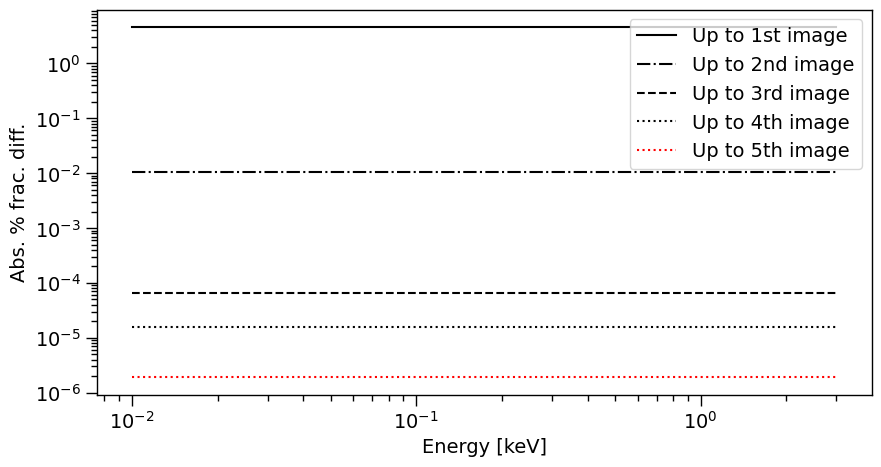

In [16]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

ax.plot(energies,
     100.0*(-temp_int1_rayX_1[:,0]/temp_int1[:,0] + 1.0),
     'k-',label="Up to 1st image")

ax.plot(energies,
         100.0*(-temp_int1_rayX_2[:,0]/temp_int1[:,0] + 1.0),
         'k-.',label="Up to 2nd image")

ax.plot(energies,
         100.0*(-temp_int1_rayX_3[:,0]/temp_int1[:,0] + 1.0),
         'k--',label="Up to 3rd image")

ax.plot(energies,
         100.0*(-temp_int1_rayX_4[:,0]/temp_int1[:,0] + 1.0),
         'k:',label="Up to 4th image")

ax.plot(energies,
         100.0*(-temp_int1_rayX_5[:,0]/temp_int1[:,0] + 1.0),
         'r:',label="Up to 5th image")

ax.set_xscale('log')
ax.set_xlabel('Energy [keV]')

ax.set_yscale('log')
ax.set_ylabel('Abs. % frac. diff.')
ax.legend()

XpsiPlot.veneer((None, None), (None, None), ax)

For this compact star only the secondary images are demonstrably important, with a massive increase in accuracy.

## Multiple images

Let's use the cached ray map to try to visualise the multiple imaging. We will use the image plane integrator to do that.

 First we need to force the spacetime to be static (otherwise univeral relations are invoked based on the stellar spin frequency as set above):

In [17]:
spacetime.a = 0.0 # spacetime spin parameter (~angular momentum)
spacetime.q = 0.0 # spacetime mass quadrupole moment

Now we call the integrator. The integrator discretises a distant image plane instead of the stellar surface. The *image* of the star is spatially resolved on the image plane. The integrator yields four-dimensional information about the signal. We trace a set of rays from the image plane to the star; the set is roughly equal in cardinality to the number of cells that discretise the surface above. Note that when this extension module is called, some output for diagnostics is directed to the terminal in which you launched this Jupyter notebook.

In [18]:
class CustomPhotospherePlotter(xpsi.PhotospherePlotter):
    """ Implement method for imaging."""

    @property
    def global_variables(self):
        """ This method is needed if we also want to invoke the image-plane signal simulator. """

        return np.array([0.0, #self.photosphere['p__super_colatitude'],
                          0.0, #self.photosphere['p__phase_shift'] * 2.0 * math.pi,
                          np.pi, #self.photosphere['p__super_radius'],
                          0.0, #self.photosphere['p__cede_colatitude'],
                          0.0, #self.photosphere['p__phase_shift'] * 2.0 * math.pi - self.photosphere['p__cede_azimuth'],
                          0.0, #self.photosphere['p__cede_radius'],
                          0.0, #self.photosphere['s__super_colatitude'],
                          0.0, #(self.photosphere['s__phase_shift'] + 0.5) * 2.0 * math.pi,
                          0.0, #self.photosphere['s__super_radius'],
                          0.0, #self.photosphere['s__cede_colatitude'],
                          0.0, #(self.photosphere['s__phase_shift'] + 0.5) * 2.0 * math.pi - self.photosphere['s__cede_azimuth'],
                          0.0, #self.photosphere['s__cede_radius'],
                          self.photosphere['temperature'], #self.photosphere['p__super_temperature'],
                          0.0, #self.photosphere['p__cede_temperature'],
                          0.0, #self.photosphere['s__super_temperature'],
                          0.0]) #self.photosphere['s__cede_temperature']])

In [19]:
plotter = CustomPhotospherePlotter(photosphere)

plotter.image(reimage = True,
                  reuse_ray_map = False,
                  energies = energies,
                  phases = everywhere.phases_in_cycles * _2pi,
                  sqrt_num_rays = 1024,
                  # squeeze rays towards limb where higher-order images are
                  image_plane_radial_increment_power=0.2, 
                  threads = 4,          # OpenMP
                  max_steps = 100000,   # max number of steps per ray
                  epsrel_ray = 1.0e-12) # ray relative tolerance

[Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz] = 1.000e-01, log10(effective temperature [K] everywhere) = 6.300e+00]
Imaging the star...
Commencing ray tracing and imaging...
Imaging the star and computing light-curves...
Calculating image plane boundary...
Image plane semi-major: 1.01
Image plane semi-minor: 1.01
Thread 0 is tracing annulus #0 of rays.
Thread 0 is tracing annulus #100 of rays.
Thread 0 is tracing annulus #200 of rays.
Thread 0 is tracing annulus #300 of rays.
Thread 0 is tracing annulus #400 of rays.
Thread 0 is tracing annulus #500 of rays.
Thread 0 is tracing annulus #600 of rays.
Thread 0 is tracing annulus #700 of rays.
Thread 0 is tracing annulus #800 of rays.
Thread 0 is tracing annulus #900 of rays.
Thread 0 is tracing annulus #1000 of rays.

Global ray map computed.
Coordinates transformed from Boyer-Lindquist to spherical.
Commencing imaging...Ray tracing complete.
Ray set cached.

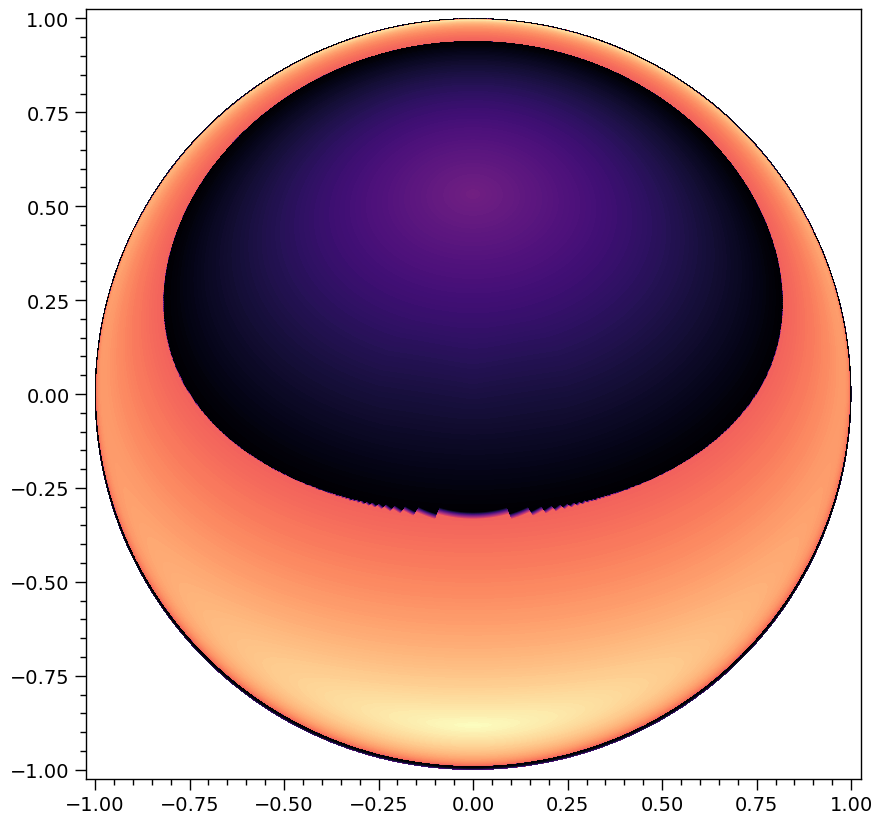

In [20]:
fig = plt.figure(figsize=(10,10))

ref = plotter.images[3].copy()
ref[ref > math.pi/2.0] *= -1.0
plt.tricontourf(plotter.images[1],
                plotter.images[2],
                ref,
                levels=np.linspace(np.min(ref[ref > -100.0]),
                                   np.max(ref[ref > -100.0]),
                                   200),
               cmap=cm.magma_r)
# rays that scatter have negative constant values <-100
# for map quantities such as the colatitude

ax = plt.gca()
ax.set_xlim([-1.025,1.025])
ax.set_ylim([-1.025,1.025])
XpsiPlot.veneer((0.05,0.25), (0.05,0.25), ax)

The artefact near the origin along the equator is because we squeezed the image-plane polar ray set towards the  image boundary, leaving fewer rays around the origin for accurate contour computation (via Delaunay triangulation).

Let's zoom in to see the second image of the southern pole more clearly:

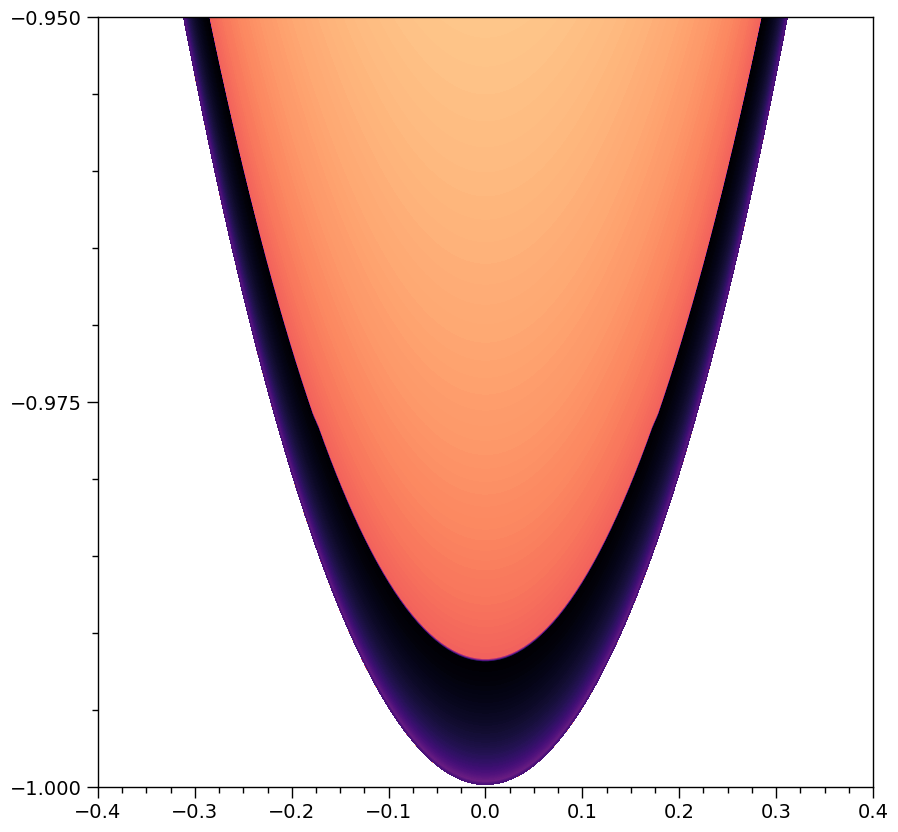

In [21]:
fig = plt.figure(figsize=(10,10))

plt.tricontourf(plotter.images[1],
                plotter.images[2],
                ref,
                levels=np.linspace(np.min(ref[ref > -100.0]),
                                   np.max(ref[ref > -100.0]),
                                   200),
               cmap=cm.magma_r)

ax = plt.gca()
ax.set_xlim([-0.4,0.4])
ax.set_ylim([-1.0,-0.95])
XpsiPlot.veneer((0.025,0.1), (0.005,0.025), ax)

Let's zoom in again to see the insane squeezing of just the third image of the southern pole:

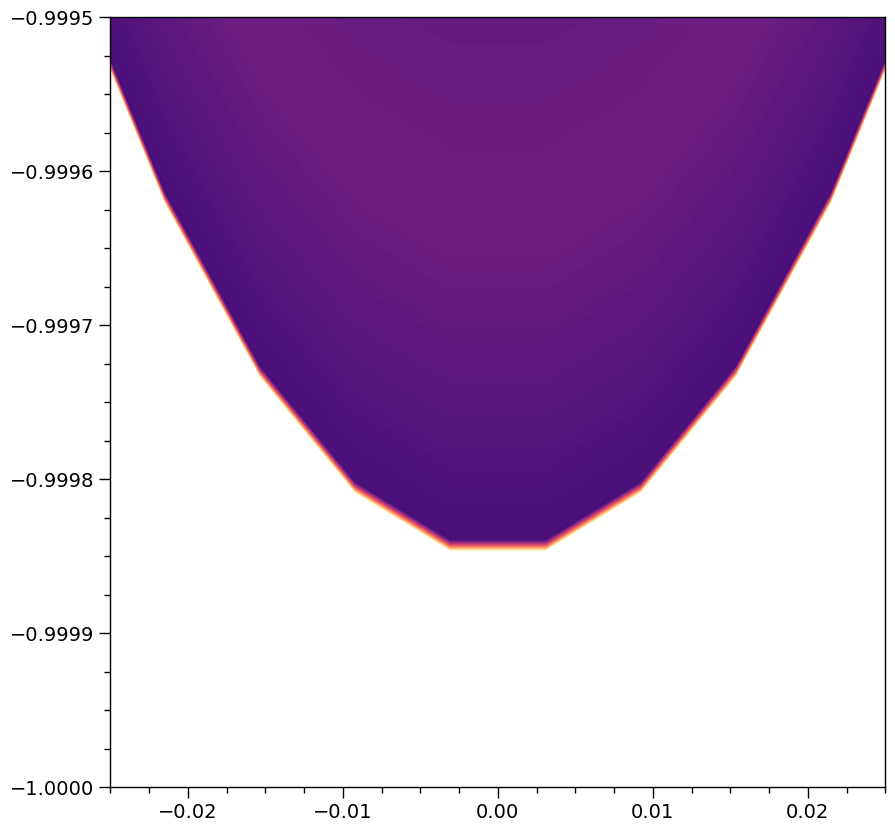

In [22]:
fig = plt.figure(figsize=(10,10))

plt.tricontourf(plotter.images[1],
                plotter.images[2],
                ref,
                levels=np.linspace(np.min(ref[ref > -100.0]),
                                   np.max(ref[ref > -100.0]),
                                   200),
               cmap=cm.magma_r)

ax = plt.gca()
ax.set_xlim([-0.025,0.025])
ax.set_ylim([-1.0,-0.9995])
_ = XpsiPlot.veneer((0.0025,0.01), (0.000025,0.0001), ax)

We'd evidently need more rays and potentially more accurate ray tracing (in particular surface detection for near-grazing rays) to resolve even these third-order images if they contributed to the flux in an important way. Note that in theory the image of this almost exactly spherical star should extend to coordinates $y=\pm1$ and $x=\pm1$ almost exactly (for an oblate star and the definition of the coordinate units, the maximum extent of the star is $x=\pm1$, with the actual extent being a function of both viewing angle and the surface oblateness and compactness). We continue discussion of performance below.

Let's first plot the azimuth map to distinguish images:

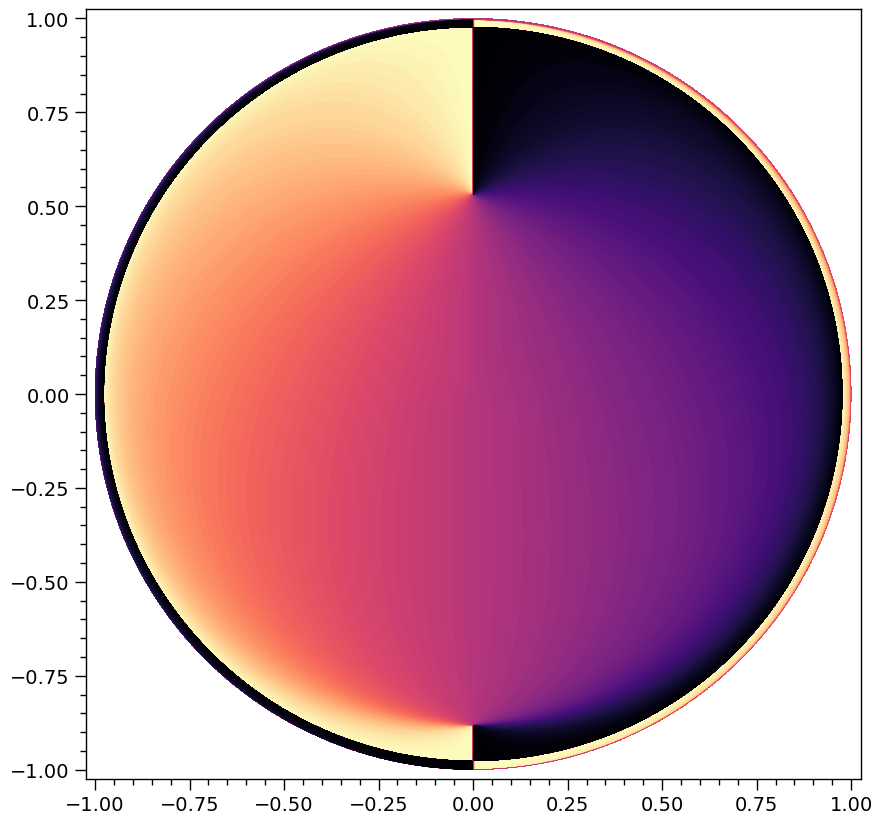

In [23]:
fig = plt.figure(figsize=(10,10))

phi = np.copy(plotter.images[4][...])

for i in range(len(phi)):
    
    if phi[i] > -100.0:
        if phi[i] > math.pi:
            while phi[i] > math.pi:
                phi[i] -= 2.0 * math.pi
        elif phi[i] < -math.pi:
            while phi[i] < -math.pi:
                phi[i] += 2.0 * math.pi

phi_lvls = np.linspace(np.min(phi[phi > -100.0]),
                       np.max(phi[phi > -100.0]), 100)

plt.tricontourf(plotter.images[1],
                plotter.images[2],
                phi,
                levels=phi_lvls,
                cmap=cm.magma_r)
# rays that scatter have negative constant values <-100
# for map quantities such as the azimuth

ax = plt.gca()
ax.set_xlim([-1.025,1.025])
ax.set_ylim([-1.025,1.025])
XpsiPlot.veneer((0.05,0.25), (0.05,0.25), ax)

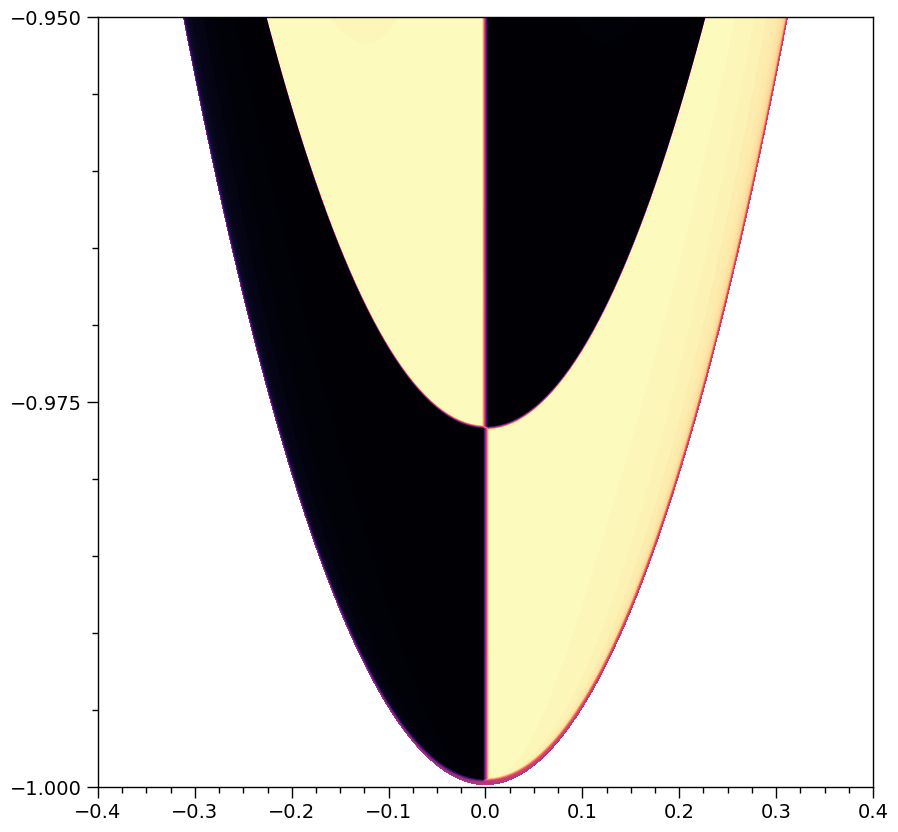

In [24]:
fig = plt.figure(figsize=(10,10))

plt.tricontourf(plotter.images[1],
                plotter.images[2],
                phi,
                levels=phi_lvls,
                cmap=cm.magma_r)

ax = plt.gca()
ax.set_xlim([-0.4,0.4])
ax.set_ylim([-1.0,-0.95])
XpsiPlot.veneer((0.025,0.1), (0.005,0.025), ax)

## Millisecond pulsar spin (phase-invariant)

Let's spin the star up to include two additional effects: relativistic beaming of the surface emission and rotational deformation (oblateness). The former means that for an observer substantially inclined to the rotational axis, the flux at (gravitationally blueshifted) energies beyond a thermal knee in the photosphere specific intensity spectrum becomes dominated by images at the edge of the stellar image on our sky (i.e., at the stellar limb). An interesting effect to note is that relatvistic beaming brightens odd-order images and dims even-order images, or vice versa dependending on whether the radiating neighbourhood of the surface is receeding or approaching based on the primary image. That means for instance, that if the primary is dimmed due to beaming, and the secondary is brightened, the tertiary image will be dimmed even more than the primary due to beaming which compounds the solid angle decay. This is one way in which a secondary image can in principle contribute at least as much flux as a primary image at some rotational phases and viewing configurations, whilst the quaternary image contributes a similar flux to the tertiary image, and so on relating adjacent odd and even order images; the tertiary and higher-order images are would be unimportant though. On the other hand, if the primary image is brightened, the secondary is dimmed and the tertiary is brightened. In this case, a tertiary image can contribute more flux than a secondary image at select phases and viewing configurations, but will itself generally be entirely dominated by the primary. The relationships between unimportant higher-order adjacent even and odd images is similar to the above description. 

*Note that another way to weight the flux integral towards the stellar limb is to have temperature inversion in the atmosphere, leading to bright near-tangential emission, but the effect is not as a strong as turning up to millisecond spin periods and higher.*

Only at energies well beyond a thermal knee in the surface emission will the relativistic beaming mean that the flux is dominated by the brightness at the stellar limb (when there is somewhat uniform, global surface emission as assumed here), where the high-order images will be squeezed. The brightness of near-tangential emission after beaming partially counteracts the solid angle decay with image order, in such a case, but will not realistically ever mean high-order images contribute more flux at some energy. However, X-ray telescopes will generally be sensitive to softer emission where there are *far* more counts, meaning relative insensitivity of a well-performing likelihood function jointly over the instrument waveband to flux integration error in the vicinity of the stellar limb.

Realistically, if a surface does not radiate somewhat unformly in the instrument waveband, leading to pulsed emission, effectively the same reasoning applies to the importance of accurately calculating the flux at phases where the flux is dominated by the signal from the stellar limb where the limb is constituted by only primary images, simply because of geometric projected effects. This is with or without additional strong relativistic beaming effects leading to flux (at energies beyond a thermal knee in the surface emission spectrum) being dominated by the contribution from the relevant radiating regions when they reach the stellar limb on the approaching side of the star.

Oblateness has the effect of increasing the maximum deflection that can be attained by a point on the surface, relative to an unperturbed spherical *background* solution. Some points, such as the locus in the vicinity of the equator only get lower in maximum deflection. In the vicinities of the poles, points gain in maximum deflection. In these cases the surface normal remains effectively radial. For intermediate points between a pole and the equator, the maximum deflection generally increases due to tilt even if the compactness coordinate decreases, but due to tilt, some images (either even or odd beyond some order) are also lost. This is because the maximum deflection depends on the ray direction aside from the angle subtended to the radial direction.

Note that for very compact stars with polar radius near the Schwarzschild photon sphere, higher order images need to graze closer and closer to the photon sphere to complete revolutions before scattering. If the surface is slightly oblate, then an opaque surface quickly truncates higher order images. Alas, for an oblate surface in this case to be valid in the ambient Schwarzschild spacetime, it would have to be effectively massless; it requires substantial rotation speed for such soft equations of state that lead to high compactness, which thus nullifies the Schwarzschild ambient spacetime and photon sphere. The issue of rotational deformation leading to a (highly compact) photosphere which lies within its own null future due to high (outgoing) ray curvature is somewhat of open problem to our knowledge but it is thought that the source matter curvature will always be too high to intercept outgoing rays that would otherwise scatter in the ambient spacetime in the absence of the opaque surface (private communication with the NICER collaboration light-curve SWG, Joonas Nättilä, and Juri Poutanen, July 2016, Seattle). Beyond this reasoning, it is not considered even mildly important for realistic experiements because the flux contribution from higher order images is so small and entirely dominated by other modelling inaccuracies.

Note that in principle, for a maximally compact toy equation of state (see, e.g., [Lattimer 2015](https://doi.org/10.1063/1.4909560) and references therein), non-rotating scale-free solutions exist within the Schwarzschild photon sphere, but rather close to it, at $R\approx1.41r_{\rm s}$.

In [25]:
spacetime['frequency'] = 205.0 # ~J0030+0451 spin

We'll reset the mass so that the oblate surface lies entirely, and barely just outside ambient Schwarzschild photon sphere:

In [26]:
star['mass'] = 2.695 # choose mass so that surface lies entirely, and barely just outside Schwarzschild photon sphere

In [27]:
spacetime.R_r_s

1.5077253212974875

In [28]:
star.update()

In [29]:
spacetime.a = 0.0 # spacetime spin parameter (~angular momentum)
spacetime.q = 0.0 # spacetime mass quadrupole moment

In [30]:
plotter.image(reimage = True,
                  reuse_ray_map = False,
                  energies = energies,
                  phases = np.linspace(0.0, 1.0, phases_in_cycles) * _2pi,
                  sqrt_num_rays = 1024,
                  # squeeze rays towards limb where higher-order images are
                  image_plane_radial_increment_power=0.33, 
                  threads = 4,          # OpenMP
                  max_steps = 100000,   # max number of steps per ray
                  epsrel_ray = 1.0e-12) # ray relative tolerance

Imaging the star...
Commencing ray tracing and imaging...
Imaging the star and computing light-curves...
Calculating image plane boundary...
Image plane semi-major: 1.00
Image plane semi-minor: 1.00
Thread 0 is tracing annulus #0 of rays.
Thread 0 is tracing annulus #100 of rays.
Thread 0 is tracing annulus #200 of rays.
Thread 0 is tracing annulus #300 of rays.
Thread 0 is tracing annulus #400 of rays.
Thread 0 is tracing annulus #500 of rays.
Thread 0 is tracing annulus #600 of rays.
Thread 0 is tracing annulus #700 of rays.
Thread 0 is tracing annulus #800 of rays.
Thread 0 is tracing annulus #900 of rays.
Thread 0 is tracing annulus #1000 of rays.

Global ray map computed.
Coordinates transformed from Boyer-Lindquist to spherical.
Commencing imaging...Ray tracing complete.
Ray set cached.
Phase-resolved specific flux integration complete.
Star imaged.


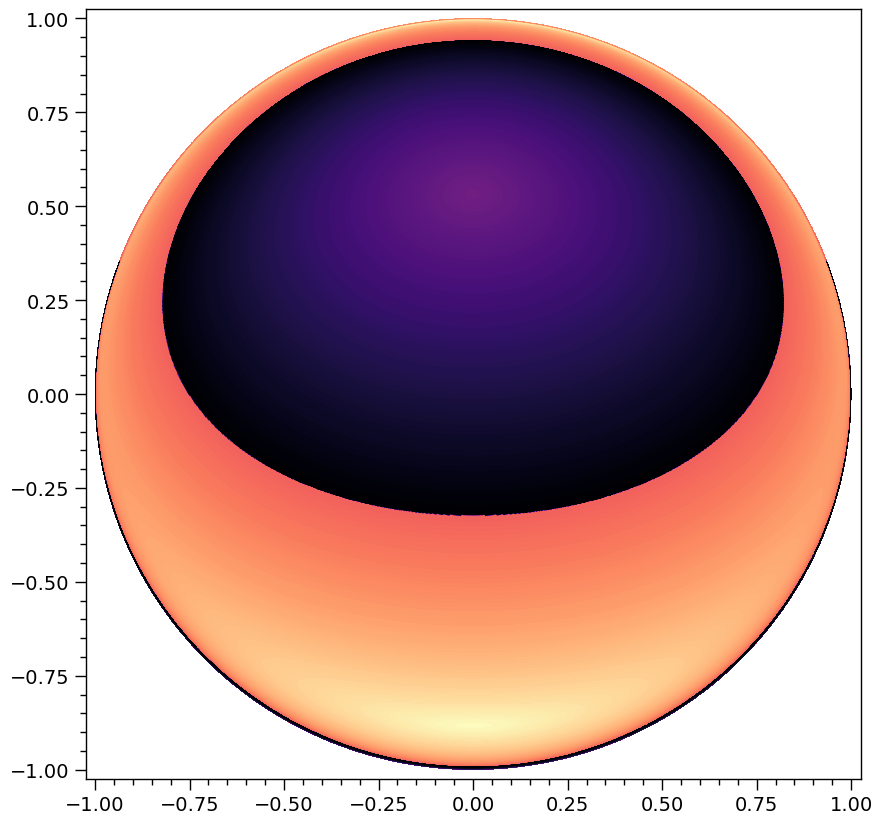

In [31]:
fig = plt.figure(figsize=(10,10))

ref = plotter.images[3].copy()
ref[ref > math.pi/2.0] *= -1.0
plt.tricontourf(plotter.images[1],
                plotter.images[2],
                ref,
                levels=np.linspace(np.min(ref[ref > -100.0]),
                                   np.max(ref[ref > -100.0]),
                                   200),
               cmap=cm.magma_r)
# rays that scatter have negative constant values <-100
# for map quantities such as the colatitude

ax = plt.gca()
ax.set_xlim([-1.025,1.025])
ax.set_ylim([-1.025,1.025])
XpsiPlot.veneer((0.05,0.25), (0.05,0.25), ax)

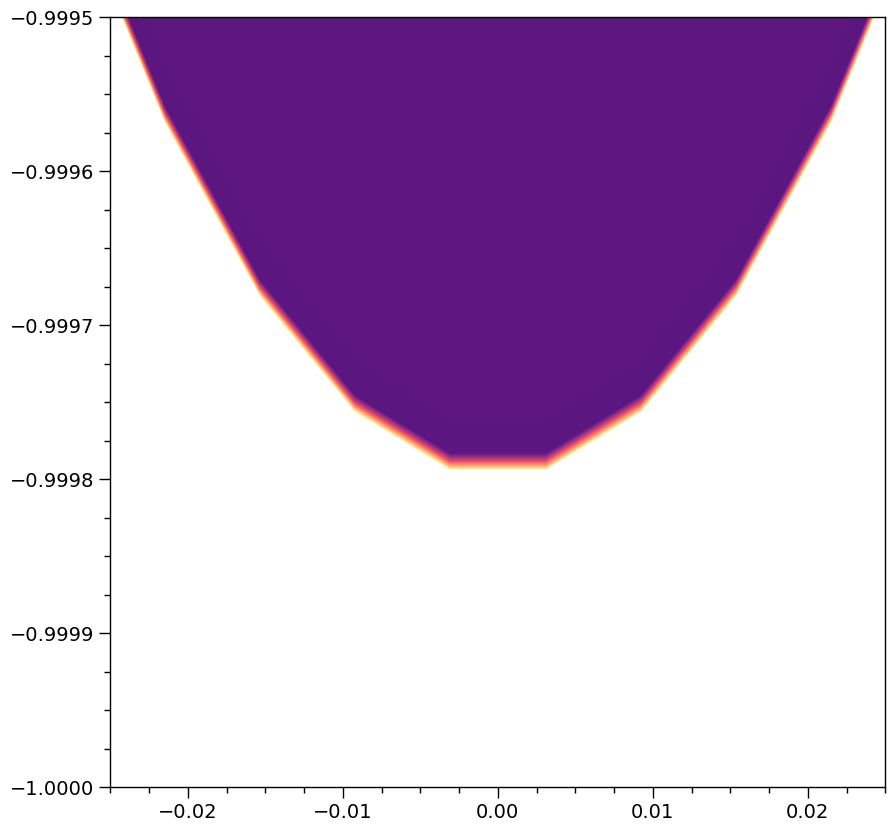

In [32]:
fig = plt.figure(figsize=(10,10))

plt.tricontourf(plotter.images[1],
                plotter.images[2],
                ref,
                levels=np.linspace(np.min(ref[ref > -100.0]),
                                   np.max(ref[ref > -100.0]),
                                   200),
               cmap=cm.magma_r)

ax = plt.gca()
ax.set_xlim([-0.025,0.025])
ax.set_ylim([-1.0,-0.9995])
_ = XpsiPlot.veneer((0.0025,0.01), (0.000025,0.0001), ax)

Notice that due to finite oblateness the resolved limb is slightly further from $y=-1$ that is the case for the effectively spherical star above. For the $x$ coordinate, the proximity to $x±1$ depends on the viewing angle and surface oblateness and compactness (besides the ray resolution).

## Custom (phase-dependent)

Let's now play with localised hot regions so that secondary images in particular can be visualised directly in intensity sky maps.

In [33]:
bounds = dict(frequency = (0.1, 600.0),
              distance = (0.1, 1.0),                     # (Earth) distance
              mass = (1.0, 3.0),                         # mass
              radius = (3.0 * gravradius(1.0), 16.0),    # equatorial radius
              cos_inclination = (0.0, 1.0))              # (Earth) inclination to rotation axis

spacetime = xpsi.Spacetime(bounds=bounds, values=dict(frequency=205.0)) # ~J0030 spin

Creating parameter:
    > Named "frequency" with bounds [1.000e-01, 6.000e+02] and initial value 2.050e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-01, 1.000e+00].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [0.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


In [34]:
bounds = dict(super_colatitude = (0.001, math.pi - 0.001),
              super_radius = (0.001, math.pi/2.0 - 0.001),
              phase_shift = (-0.25, 0.75),
              super_temperature = (5.1, 6.8))

primary = xpsi.HotRegion(bounds=bounds,
                            values={},
                            symmetry=True,
                            omit=False,
                            cede=False,
                            concentric=False,
                            sqrt_num_cells=512,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=1024,
                            num_leaves=1024,
                            num_phases=100,
                            num_rays=1024,
                            is_antiphased=False,
                            prefix='p')

bounds = dict(super_colatitude = (0.001, math.pi - 0.001),
              super_radius = (0.001, math.pi/2.0 - 0.001),
              phase_shift = (-0.25, 0.75),
              super_temperature = (5.1, 6.8))

secondary = xpsi.HotRegion(bounds=bounds,
                            values={},
                            symmetry=True,
                            omit=False,
                            cede=False,
                            concentric=False,
                            sqrt_num_cells=512,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=1024,
                            num_leaves=1024,
                            num_phases=100,
                            num_rays=1024,
                            is_antiphased=True,
                            prefix='s')

from xpsi import HotRegions

hot = HotRegions((primary, secondary))

Creating parameter:
    > Named "super_colatitude" with bounds [1.000e-03, 3.141e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [1.000e-03, 1.570e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [-2.500e-01, 7.500e-01].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "super_temperature" with bounds [5.100e+00, 6.800e+00].
    > log10(superseding region effective temperature [K]).
Creating parameter:
    > Named "super_colatitude" with bounds [1.000e-03, 3.141e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [1.000e-03, 1.570e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [-2.500e-01, 7.5

In [35]:
class derive(xpsi.Derive):
    def __init__(self):
        pass
    def __call__(self, boundto, caller = None):
        global spacetime
        return spacetime['frequency']

In [36]:
photosphere = xpsi.Photosphere(hot = hot,
                                elsewhere = None,
                                everywhere = None,
                                values=dict(mode_frequency = derive()))

Creating parameter:
    > Named "mode_frequency" that is derived from ulterior variables.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].


In [37]:
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

In [38]:
# (Earth) distance
star['distance'] = 0.33
# gravitational mass
star['mass'] = 2.695
# coordinate equatorial radius
star['radius'] = 12.0
# (Earth) inclination to rotation axis
star['cos_inclination'] = 0.0

star['p__phase_shift'] = 0.0
# isotropic blackbody temperature
star['p__super_temperature'] = 6.3
star['p__super_colatitude'] = 1.0
star['p__super_radius'] = 0.2

star['s__phase_shift'] = 0.0
# isotropic blackbody temperature
star['s__super_temperature'] = 6.3
star['s__super_colatitude'] = math.pi - 1.0
star['s__super_radius'] = 0.2

In [39]:
star.update()

In [40]:
energies = np.logspace(-2.0, np.log10(3.0), 100, base=10.0)

In [41]:
spacetime.a = 0.0 # spacetime spin parameter (~angular momentum)
spacetime.q = 0.0 # spacetime mass quadrupole moment

Now we call the image-plane integrator.

In [42]:
class CustomPhotospherePlotter(xpsi.PhotospherePlotter):
    """ Implement method for imaging."""

    @property
    def global_variables(self):
        """ This method is needed if we also want to invoke the image-plane signal simulator. """

        return np.array([ self.photosphere['p__super_colatitude'],
                          self.photosphere['p__phase_shift'] * 2.0 * math.pi,
                          self.photosphere['p__super_radius'],
                          0.0, #self['p__cede_colatitude'],
                          0.0, #self['p__phase_shift'] * 2.0 * math.pi - self['p__cede_azimuth'],
                          0.0, #self['p__cede_radius'],
                          self.photosphere['s__super_colatitude'],
                          (self.photosphere['s__phase_shift'] + 0.5) * 2.0 * math.pi,
                          self.photosphere['s__super_radius'],
                          0.0, #self['s__cede_colatitude'],
                          0.0, #(self['s__phase_shift'] + 0.5) * 2.0 * math.pi - self['s__cede_azimuth'],
                          0.0, #self['s__cede_radius'],
                          self.photosphere['p__super_temperature'],
                          0.0, #self['p__cede_temperature'],
                          self.photosphere['s__super_temperature'],
                          0.0]) #self['s__cede_temperature']])

In [43]:
plotter = CustomPhotospherePlotter(photosphere)

[Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz] = 2.050e+02, The phase of the hot region, a periodic parameter [cycles] = 0.000e+00, The colatitude of the centre of the superseding region [radians] = 1.000e+00, The angular radius of the (circular) superseding region [radians] = 2.000e-01, log10(superseding region effective temperature [K]) = 6.300e+00, The phase of the hot region, a periodic parameter [cycles] = 0.000e+00, The colatitude of the centre of the superseding region [radians] = 2.142e+00, The angular radius of the (circular) superseding region [radians] = 2.000e-01, log10(superseding region effective temperature [K]) = 6.300e+00]


In [44]:
sky_map_kwargs = {'panel_indices': (0,1,2,3,4,5),
                  'num_levels': 100, # in intensity field rendering
                  'colormap': cm.Purples_r,
                  'phase_average': False,
                  'annotate_energies': True,  # background from the surface and behind the star
                  'energy_annotation_format': '[%.2f keV]',
                  'annotate_location': (0.025,0.025)}
    
# you can install ffmpeg with conda in order to animate
animate_kwargs = {'cycles': 4, 'fps': 32}

In [45]:
plotter.image(reimage = True,
                  reuse_ray_map = False,
                  cache_intensities = 1.0, # cache size limit in GBs
                  energies = np.array([0.01,0.1,0.5,1.0,2.0,5.0]),
                  phases = np.linspace(0.0, 1.0, 96) * _2pi,
                  sqrt_num_rays = 512, # do not need as many to see the important images
                  threads = 4,
                  max_steps = 100000,
                  epsrel_ray = 1.0e-12,
                  plot_sky_maps = True, # activate if you want to plot frames
                  sky_map_kwargs = sky_map_kwargs, 
                  animate_sky_maps = False, # activate if you want to animate
                  free_memory = False, # activate if memory is a concern, to delete ray-map/intensity caches
                  animate_kwargs = animate_kwargs)

Imaging the star...
Commencing ray tracing and imaging...
Imaging the star and computing light-curves...
Calculating image plane boundary...
Image plane semi-major: 1.00
Image plane semi-minor: 1.00
Thread 0 is tracing annulus #0 of rays.
Thread 0 is tracing annulus #100 of rays.
Thread 0 is tracing annulus #200 of rays.
Thread 0 is tracing annulus #300 of rays.
Thread 0 is tracing annulus #400 of rays.
Thread 0 is tracing annulus #500 of rays.

Global ray map computed.
Coordinates transformed from Boyer-Lindquist to spherical.
Commencing imaging...Ray tracing complete.
Ray set cached.
Intensity caching complete.
Plotting intensity sky maps...
Normalising each sky map panel separately...
Normalised sky map panels separately.
Rendering image numbers [1, 10]...
Rendering image numbers (10, 20]...
Rendering image numbers (20, 30]...
Rendering image numbers (30, 40]...
Rendering image numbers (40, 50]...
Rendering image numbers (50, 60]...
Rendering image numbers (60, 70]...
Rendering imag

If you are executing this notebook, you can view the video file:

In [46]:
%%HTML
<div align="middle">
<video width="100%" controls loop>                                                                                                                   
    <source src="images/skymap_animated.mp4" type="video/mp4">                                                                     
</video></div>

In [47]:
!mkdir images/frames_multiple_imaging
!mv images/*.png images/frames_multiple_imaging/.

mkdir: cannot create directory ‘images/frames_multiple_imaging’: File exists


Here is a frame for the purpose of the documentation notebook. Each panel displays the photon specific intensity field, on the sky, at a given energy; energy increases from top-left to bottom-right. The intensity field in each panel is normalised over sky direction and phase, for each energy in the sequence.

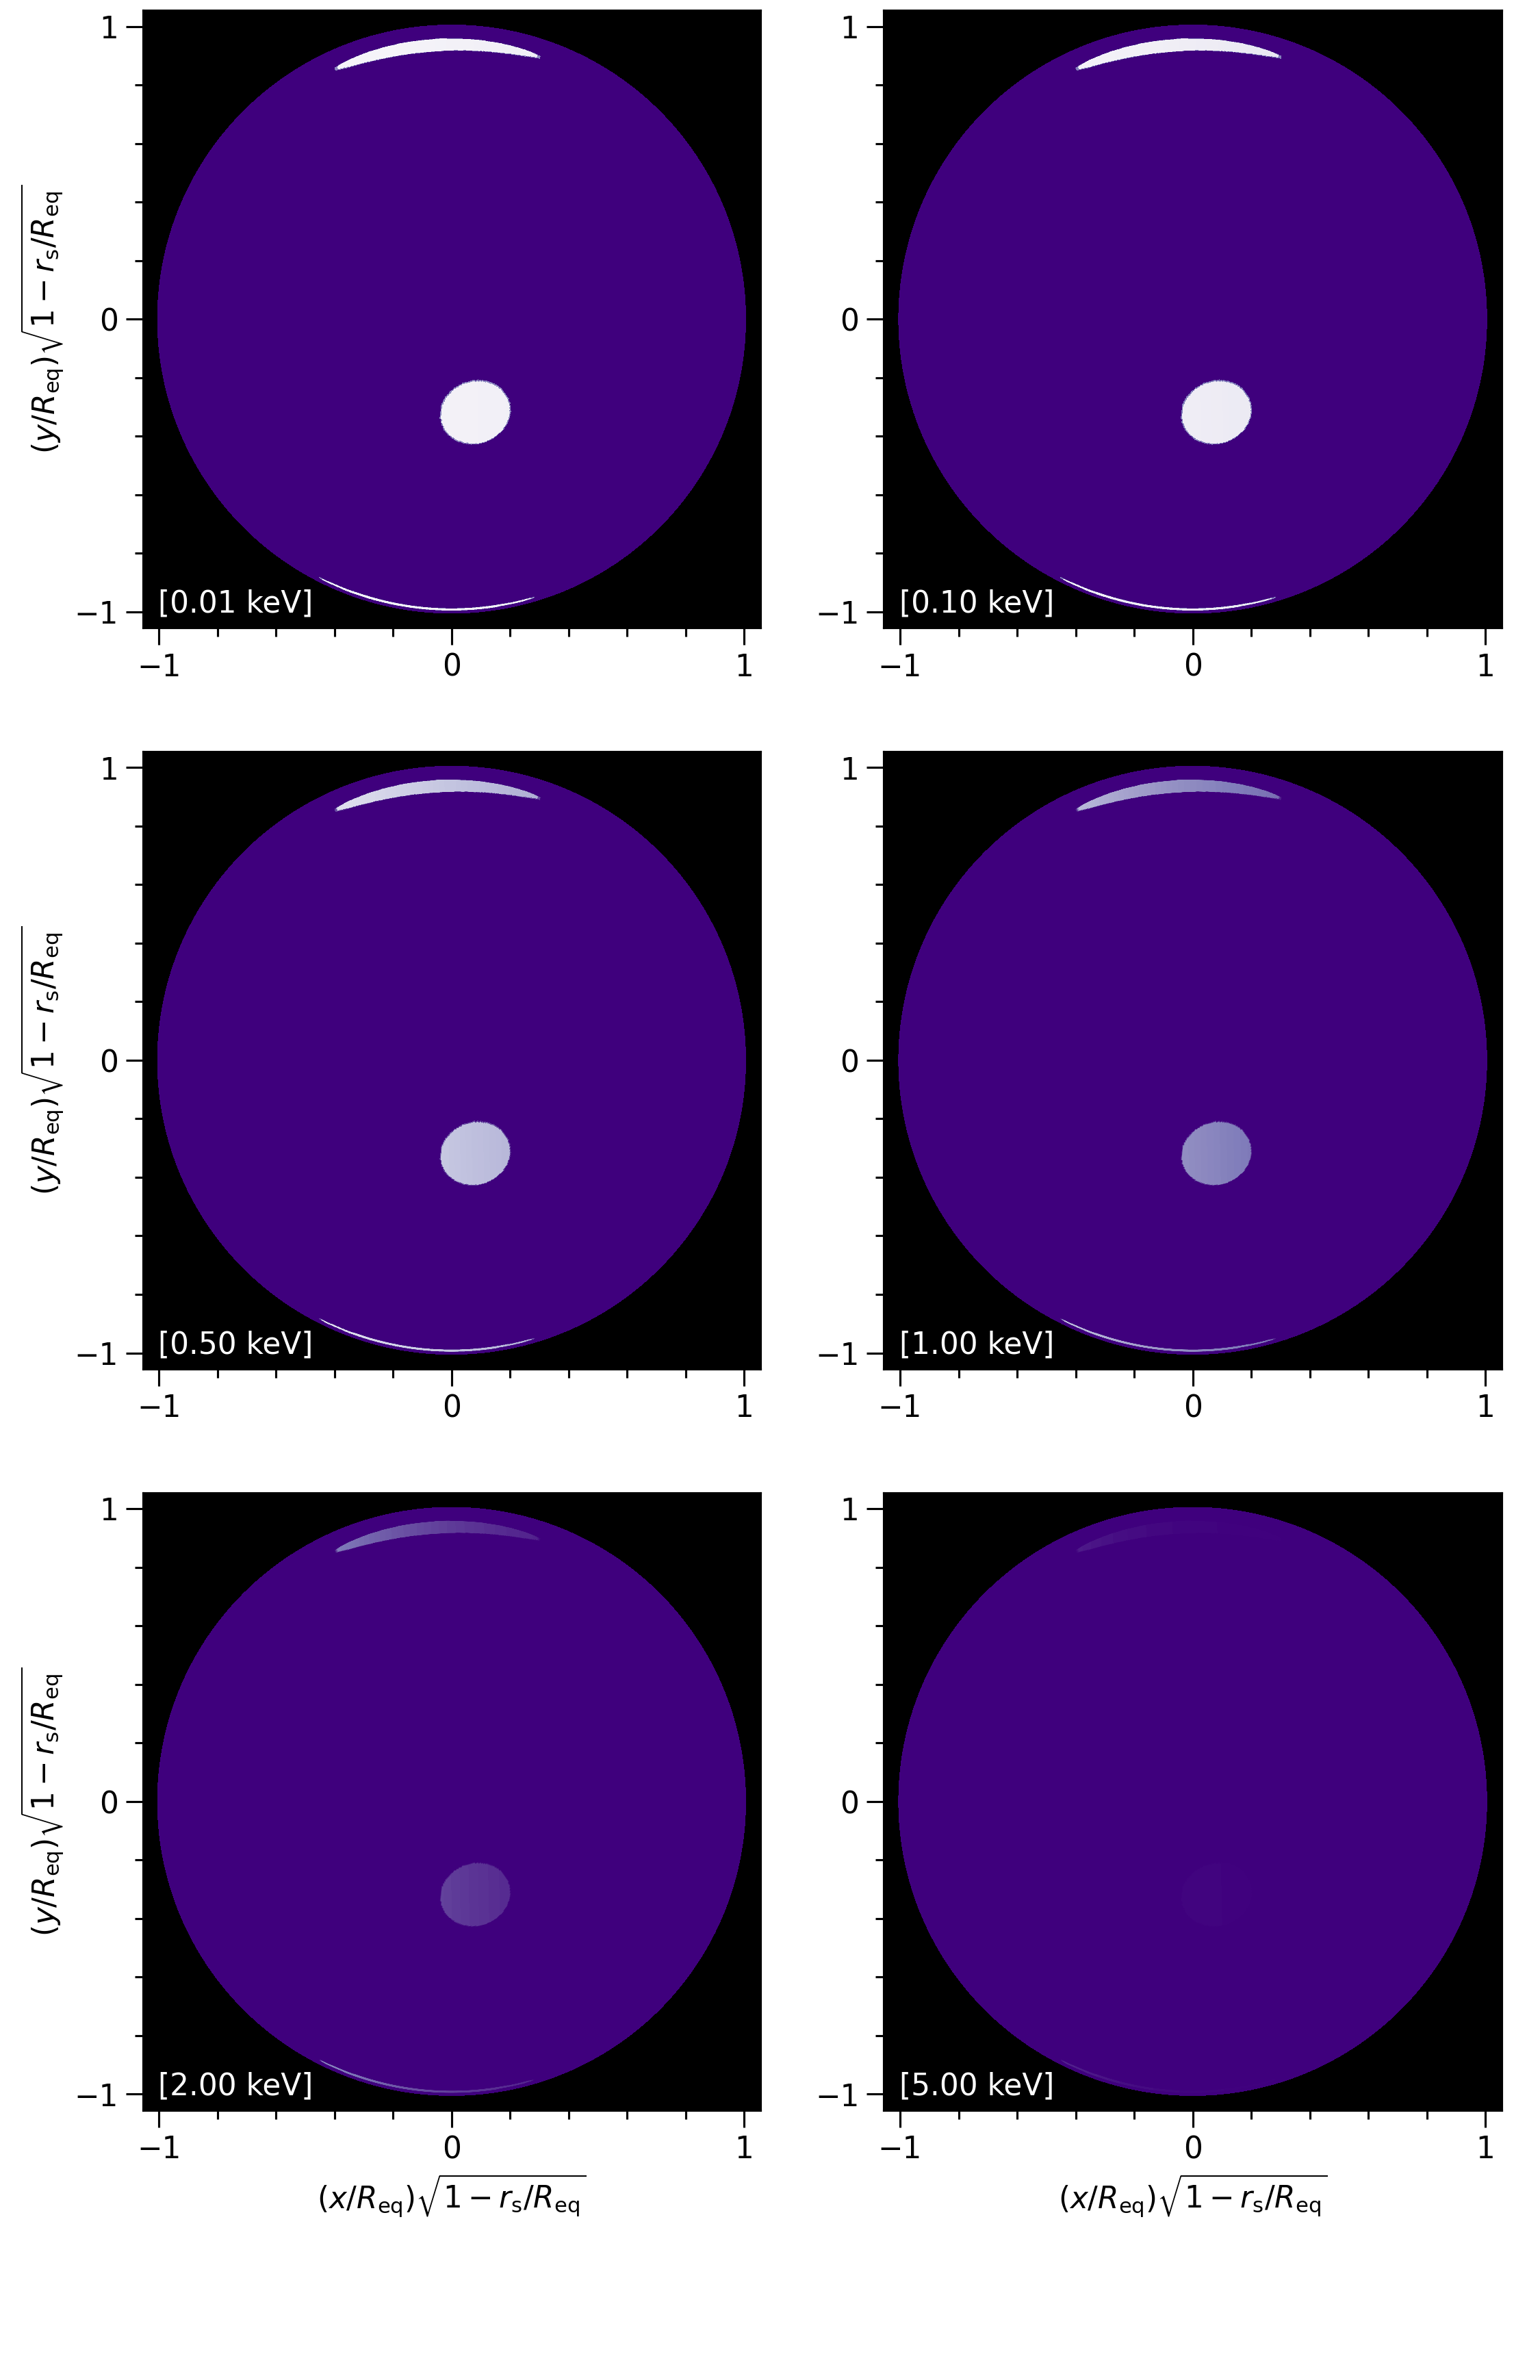

In [48]:
Image("./images/frames_multiple_imaging/skymap_50.png")

Finally, let's phase-average the intensity sky maps:

In [49]:
sky_map_kwargs['phase_average'] = True
# only one set of panels so why not choose higher res.?
sky_map_kwargs['num_levels'] = 500

plotter.image(reimage = False, # because we decided not to free_memory earlier
                  energies = np.array([0.01,0.1,0.5,1.0,2.0,5.0]),
                  phases = np.linspace(0.0, 1.0, 96) * _2pi,
                  plot_sky_maps = True,
                  sky_map_kwargs = sky_map_kwargs)

Imaging the star...
Plotting intensity sky maps...
Averaging (specific) intensity over rotational phase...
Averaged (specific) intensity over rotational phase.
Normalising each sky map panel separately...
Normalised sky map panels separately.
Rendering phase-averaged images...
Intensity sky maps plotted.
Star imaged.


In [50]:
!mv images/skymap_0.png images/frames_multiple_imaging/skymap_multiple_imaging_phase_averaged.png

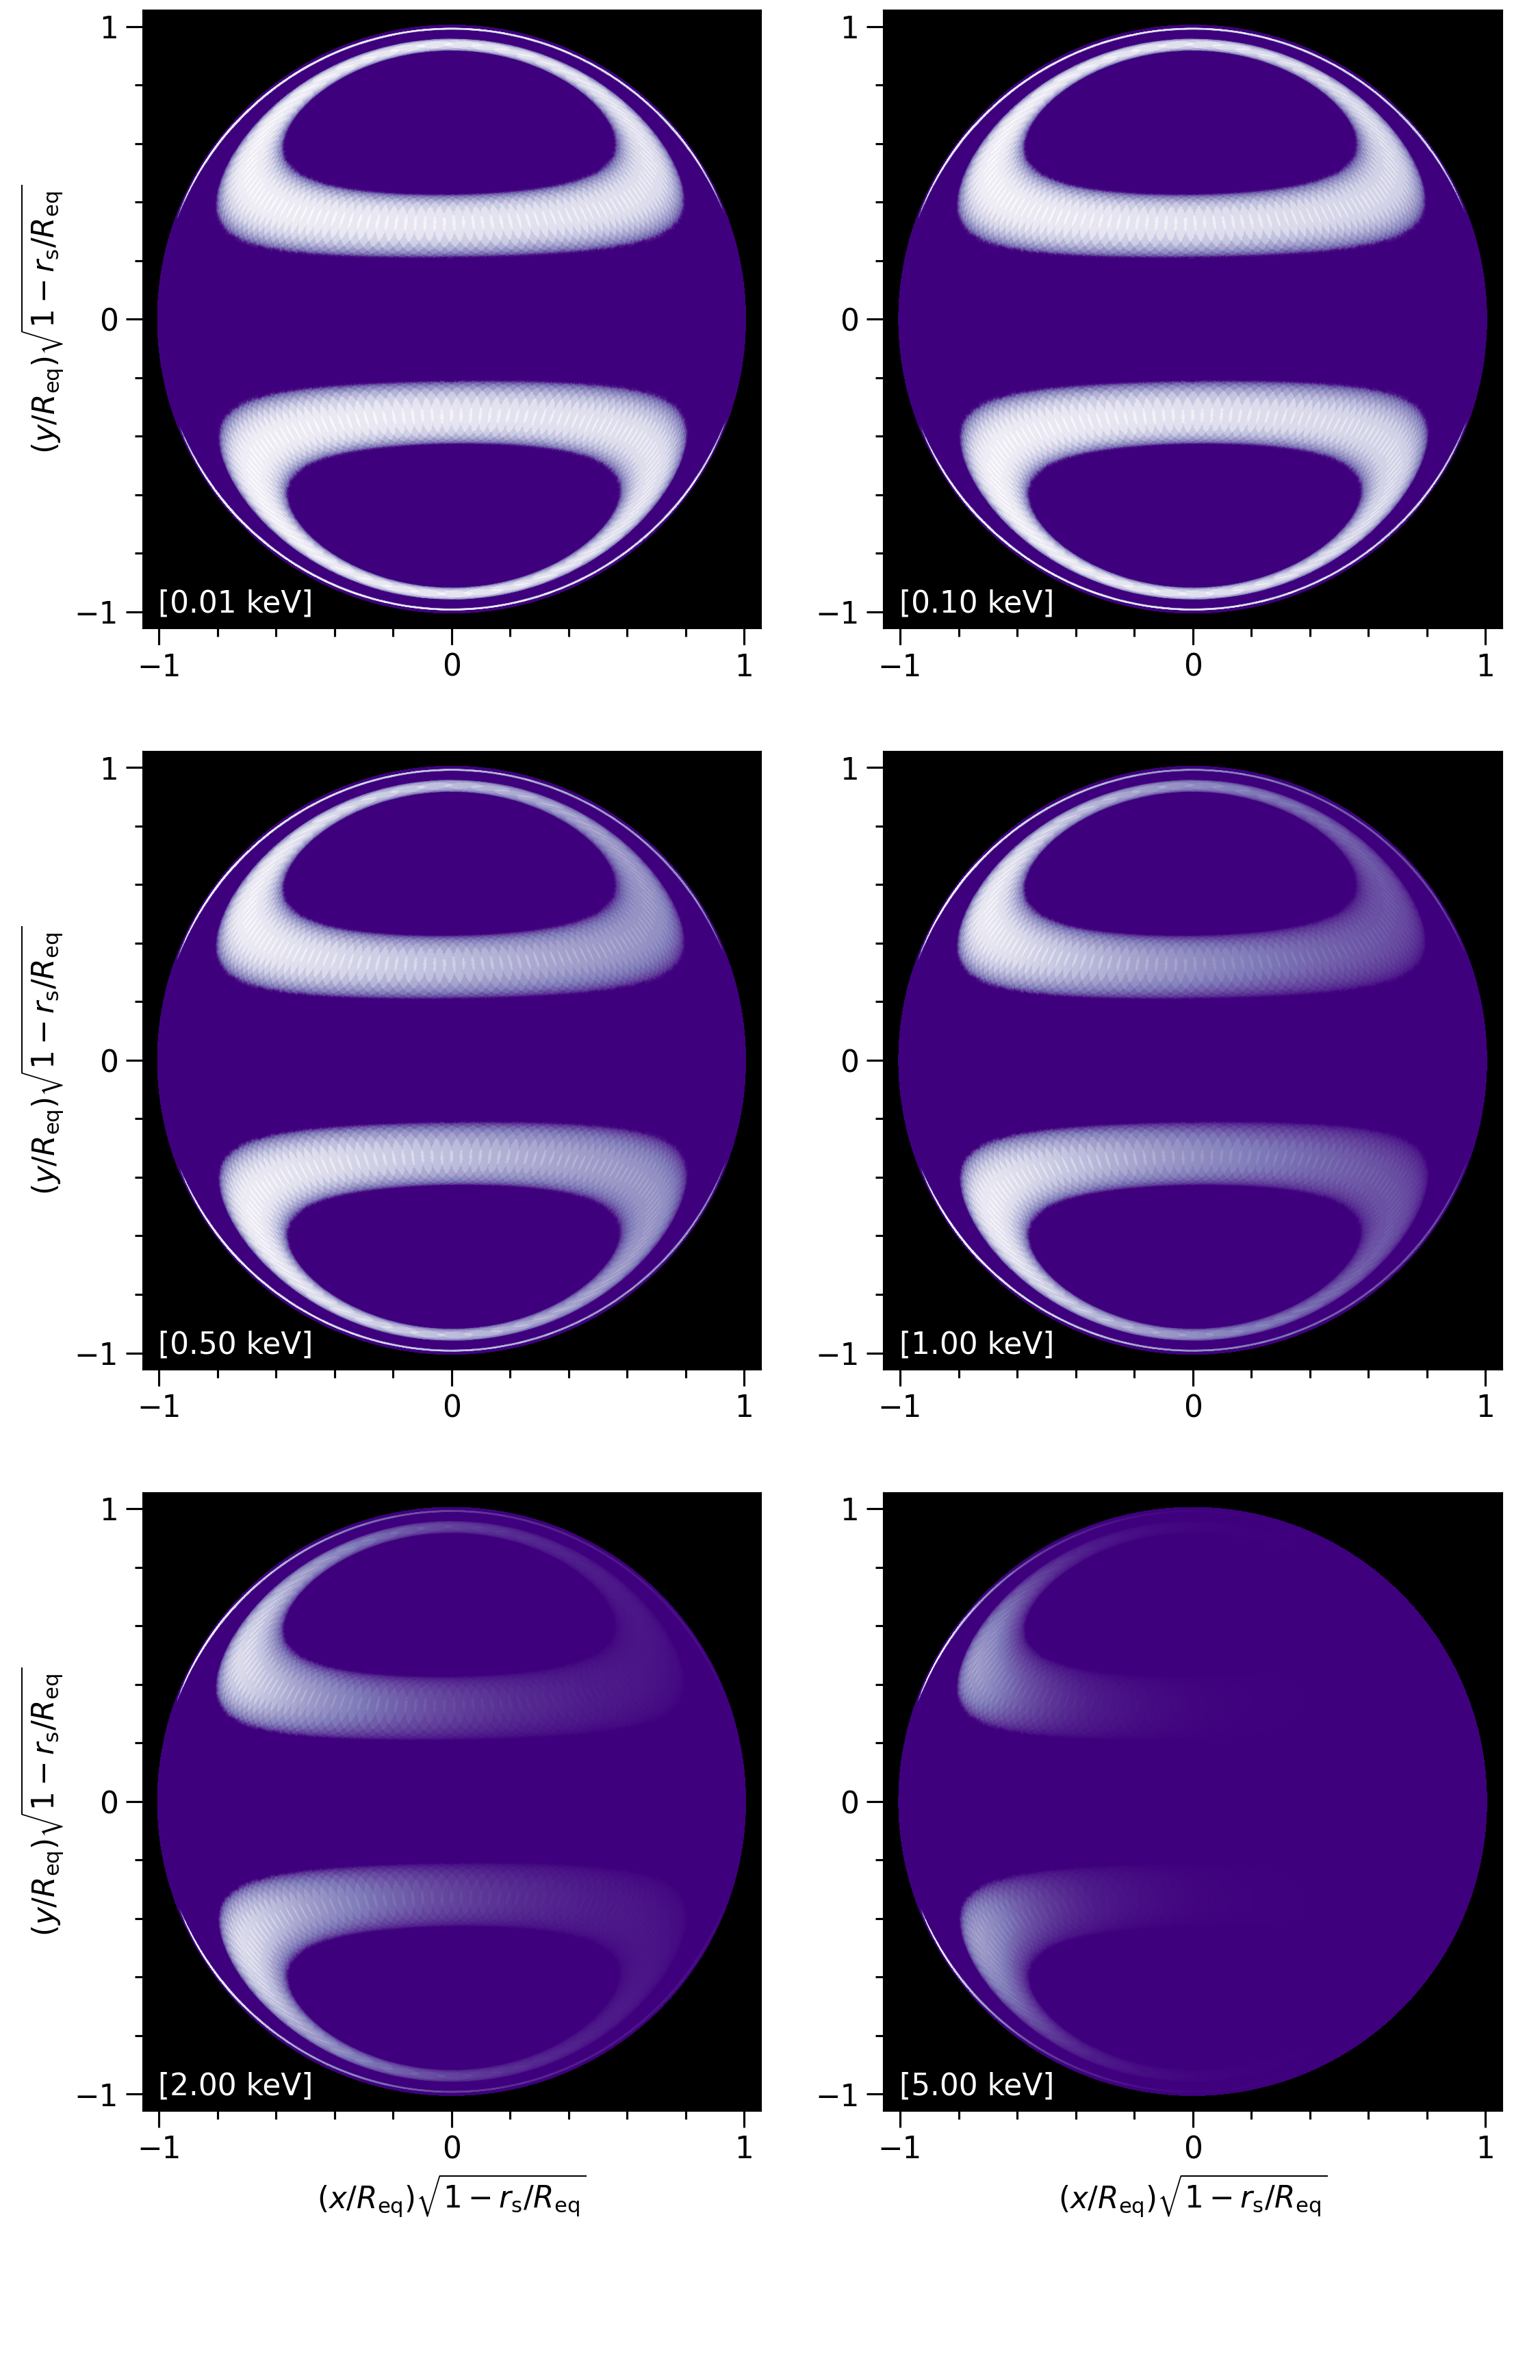

In [51]:
Image("images/frames_multiple_imaging/skymap_multiple_imaging_phase_averaged.png")